In [ ]:
## Import neccessary packages
import pandas as pd
from csv import reader
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns


In [ ]:
## Reading dataset
car = pd.read_csv("car_evaluation.csv",header=None)
car.columns =['buying', 'maint', 'doors', 'persons','lug_boot','safety','class']

In [ ]:
## Checking dataset on number of values in each values, missing value, outliers

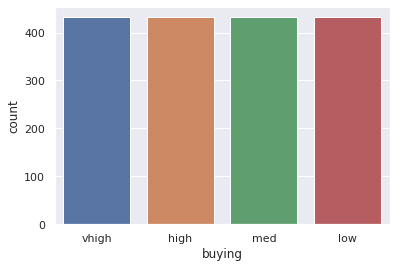

In [ ]:
## Show the number values of each column
sns.set(style="darkgrid")
ax = sns.countplot(x="buying", data=car)

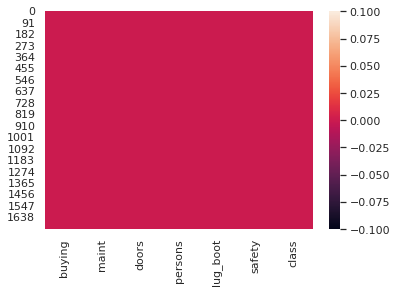

In [ ]:
## Show the missing values of each column
sns.heatmap(car.isnull(),\
            # yticklabels=False,cbar=False,cmap="blue"
            )


In [ ]:
####### Preprocessing data

In [ ]:
## Encoding data
car["buying_encoding"] = np.where(car["buying"] == "vhigh", 1,
                                  np.where(car["buying"] == "high", 2,
                                           np.where(car["buying"] == "med", 3,4)
                                  ))
car["maint_encoding"] = np.where(car["maint"] == "vhigh", 1,
                                  np.where(car["maint"] == "high", 2,
                                           np.where(car["maint"] == "med", 3,4)
                                  ))
car["lug_boot_encoding"] = np.where(car["lug_boot"] == "big", 1,
                                  np.where(car["lug_boot"] == "med", 2,3)
                                  )
car["safety_encoding"] = np.where(car["safety"] == "high", 1,
                                  np.where(car["safety"] == "med", 2,3)
                                  )
car["doors_encoding"] = np.where(car["doors"] == "2", 1,
                                  np.where(car["doors"] == "3", 2,
                                           np.where(car["doors"] == "4", 3,4)
                                  ))
car["persons_encoding"] = np.where(car["persons"] == "2", 1,
                                  np.where(car["persons"] == "4", 2,3)
                                  )
car["class_encoding"] = np.where(car["class"] == "unacc",0,1)

In [ ]:
## Select columns
car_encode = car[["buying_encoding","maint_encoding","doors_encoding",\
                  "persons_encoding","lug_boot_encoding","safety_encoding","class_encoding"]]

In [ ]:
## Define Function

In [ ]:
def train_test(orginal_dataset,percent):
  '''
  This function is to split dataset into training and testing data and differentiate variable columns and class column
  Orginal_dataset: the data need to be splited
  Persent: how many percent to split training set
  '''
  ## Split dataset into training and testing data
  sz = len(orginal_dataset) ## Counting number of row in orginal_dataset
  cut = int(percent * sz)
  shuffled_l = car_encode.sample(frac=1) ## shiffle the dataset
  train = shuffled_l[:cut] # first percent% of dataset will be training set
  test = shuffled_l[cut:] # last (1-percent)% of dataset will be testing set

  ## Differentiate variable columns and class column
  x_train = train.drop(["class_encoding"],1)
  x_test = test.drop(["class_encoding"],1)
  y_train = train.drop(["buying_encoding","maint_encoding","doors_encoding",\
                  "persons_encoding","lug_boot_encoding","safety_encoding",],1)
  y_test = test.drop(["buying_encoding","maint_encoding","doors_encoding",\
                  "persons_encoding","lug_boot_encoding","safety_encoding",],1)
  return x_train,x_test,y_train,y_test

In [ ]:
def KNN_predict(x_train,y_train,x_test,k):
  '''
  This function is measure the distance of a row in common testing dataset to entirely common training dataset then
  based on the class of k points nearest the point in class training data set to predict the class of the row in
  common testing dataset (Meaning which class dominates in the group of nearest point will be the class of it)
  x_train: common training dataset (meaning including column without class of training dataset)
  y_train: class training dataset (meaning including only the class of training dataset)
  x_test: common testing dataset (meaning including column without class of testing dataset)
  k: expected nearest points in training set to a given point in testing dataset
  '''
  prediction = []
  for i in range(len(x_test)):
  ## calculate distancee by euclidean for each test row and match to class training dataset
    dist = ((x_test.iloc[i] - x_train)**2)
    y_train['distance'] = dist.sum(axis=1).apply(np.sqrt)
  ## Arrange the distance ascendingly to find k nearest point
    y_train.sort_values(by=['distance'], inplace=True)
  ## Pick k nearest points and count number of values of each class then choose the one appeared the most
    class_choose = y_train["class_encoding_2"][:k].value_counts().idxmax()
    prediction.append(class_choose)
  return prediction

In [ ]:
def Predict_and_checking_accuracy(x_train,y_train,x_test,y_test,k):
  '''
  This function is to run the function KNN_predict and validate the result
  and showing the running time of each model according to each expected K
  x_train, y_train, x_test,k: datasets are applied to run function KNN_predict
  y_test: to compare with the prediction from the function KNN_predict
  '''
  start_time = datetime.now()

  y_test["prediction"] = KNN_predict(x_train,y_train,x_test,k)

  ## Measure the running time of each model
  end_time = datetime.now()
  Running_time = format(end_time - start_time)

  ## Calculate Accuracy of the dataset
  y_test['comparison'] = np.where(y_test['class_encoding_2'] == y_test['prediction'], "True", "False")
  Accuracy = (len(y_test[y_test['comparison'] == "True"])/ \
              (len(y_test[y_test['comparison'] == "True"])+ \
               len(y_test[y_test['comparison'] == "False"])))*100

  ## Calculate Precision and recall of the dataset (Precision = TP/(TP+FP), Recall = TP/(TP+FN))
  y_test['Confusion_matrix']  = np.where((y_test['class_encoding_2'] == 1)&(y_test['prediction'] == 1),"True_positive",\
          np.where((y_test['class_encoding_2'] == 1)&(y_test['prediction'] == 2),"False_positive",
                    np.where((y_test['class_encoding_2'] == 2)&(y_test['prediction'] == 1),"False_negative","True_negative")
                    )
          )
  Precision =  (len(y_test[y_test['Confusion_matrix'] == "True_positive"])/ \
                (len(y_test[y_test['Confusion_matrix'] == "True_positive"])+\
                len(y_test[y_test['Confusion_matrix'] == "False_positive"])))*100

  Recall =  (len(y_test[y_test['Confusion_matrix'] == "True_positive"])/ \
            (len(y_test[y_test['Confusion_matrix'] == "True_positive"])+ \
              len(y_test[y_test['Confusion_matrix'] == "False_negative"])))*100
  return k,Accuracy,Precision,Recall,Running_time

In [ ]:
## Apply and Run function to complete the model

In [ ]:
## Spliting data
x_train,x_test,y_train,y_test = train_test(car_encode,0.8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


In [ ]:
## Finding the appropriate number of K for the dataset
Standard_K = int(sqrt(len(car_encode)))

## Running model from 1 to Standard_K
Result_of_each_k = []
for k in range(1,Standard_K,2):
    final_result = Predict_and_checking_accuracy(x_train,y_train,x_test,y_test,k)
    Result_of_each_k.append(final_result)
final_result = pd.DataFrame(Result_of_each_k, columns = ["k","Accuracy","Precision","Recall","Running_time"])

In [ ]:
final_result

,k,Accuracy,Precision,Recall,Running_time
0,1,85.549133,78.787879,72.897196,0:00:00.804643
1,3,94.508671,86.868687,93.478261,0:00:00.790103
2,5,98.265896,96.969697,96.969697,0:00:00.760917
3,7,97.976879,94.949495,97.916667,0:00:00.766150
4,9,98.265896,94.949495,98.947368,0:00:00.766863
5,11,97.398844,92.929293,97.872340,0:00:00.760168
6,13,96.820809,93.939394,94.897959,0:00:00.767787
7,15,97.398844,94.949495,95.918367,0:00:00.759791
8,17,96.531792,92.929293,94.845361,0:00:00.790964
9,19,95.664740,89.898990,94.680851,0:00:00.770959


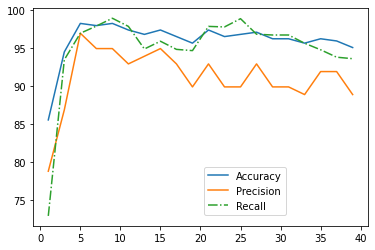

In [ ]:
# Visualize the result by line chart
plt.plot(final_result["k"], final_result["Accuracy"], label = "Accuracy")
plt.plot(final_result["k"], final_result["Precision"], label = "Precision",linestyle="-")
plt.plot(final_result["k"], final_result["Recall"], label = "Recall",linestyle="-.")
plt.legend(loc=(0.51, 0.05)) ## Modify the position of legend
plt.show()